# COE347 HW4
**Author: Alex Choi** <br>
*Date: 2025-02-17*

---
## Question 1
The Forward Difference Approximation is:
$$ u(x+h) = u(x) + h u'(x) + \frac{h^2}{2!} u''(x) + \frac{h^3}{3!} u'''(x) + \frac{h^4}{4!} u^{(4)}(x) + \dots $$
The Backward Differene Approximation is:
$$ u(x-h) = u(x) - h u'(x) + \frac{h^2}{2!} u''(x) - \frac{h^3}{3!} u'''(x) + \frac{h^4}{4!} u^{(4)}(x) + \dots $$
Switch to index notation and add $ u(x+h) $ and $ u(x-h) $
$$
u_{i+1} + u_{i-1} = 2 u_i + h^2 u''_i + \frac{h^4}{4!} u^{(4)}(x) + h.o.t.
$$
Now, rearrange:

$$
h^2 u''_i = u_{i+1} - 2u_i + u_{i-1} - \frac{h^4}{4!} u^{(4)}(x_i) + h.o.t.
$$

Here, we can clearly see that:
$$
C = -\frac{1}{4!} = -\frac{1}{24}
$$

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # for tabular displays
from scipy.linalg import solve, solve_banded # for efficeint solver of tridiagonal system.
from scipy.interpolate import PchipInterpolator # need for 3rd order interpolation of exact solution
from scipy.stats import linregress
from pprint import pprint
from IPython.display import display, Markdown, HTML


# we will go ahead and define a helper function to read in exact solution file for latr use
def read_dat_file(filename = str) -> tuple:
    # Load the data from the file
    data = np.loadtxt(filename)

    # Extract x and y values (assuming two columns)
    return np.array(data[:, 0]), np.array(data[:, 1])

# let's first define our ODE, or a given function
def ode_eq1(x):
    """
    Returns f(x) = (4π)^2 cos(4πx)
    """
    return 16 * (np.pi ** 2) * np.cos(4 * np.pi * x)
    

---
## Question 2
Here, we implement a numerical solution to the given boundary value problem using the second-order finite difference formula (FDF) for approximating $u''(x)$. We discretize the domain, construct a system of linear equations, and solve for $u_i$ at interior points. The numerical solution is obtained for $N = 10$ and can be compared against the exact solution provided in the dataset.

We first have to attain a matrix-vector form of our linear systems of equations for all values of $u_i$

Given our ODE:
$$
u''(x) = f(x) = (4\pi)^2 \cos(4\pi x) = 16\pi^2 \cos(4\pi x) \quad \text{(1)}
$$

And Given our Second-Order Finite Difference Approximation:
$$
u''(x_i) h^2 = u_{i+1} - 2u_i + u_{i-1} + \mathcal{O}(h^2) \quad \text{(2)}
$$

Equating (1) and (2):

$$
h^2 16\pi^2 \cos(4\pi x_i) = u_{i+1} - 2u_i + u_{i-1} \quad \text{(3)}
$$

Converting to a System of Equations:

$$
h^2
\begin{bmatrix}
f_1 - u(0) \\
f_2 \\
\vdots \\
f_N - u(1)
\end{bmatrix}
=
\begin{bmatrix}
-2 & 1  & 0  & \dots  & 0  \\
1  & -2 & 1  & \dots  & 0  \\
0  & 1  & -2 & \dots  & 0  \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0  & 0  & 0  & 1  & -2
\end{bmatrix}
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_N
\end{bmatrix}
$$

where:
- The **main diagonal** is filled with **-2**.
- The **superdiagonal** and **subdiagonal** are filled with **1**.
- The right-hand side includes **boundary conditions** at $x = 0$ and $x = 1$.

This forms a **tridiagonal system** that we can solve numerically.

### Construct the BVP solver

In [119]:
# now formulate the BVP solver for our ODE:
def solve_bvp(ode, x_range: list, u_i: float, u_f: float, N: int):
    """
    Solves a boundary value problem (BVP) using the second-order finite difference method (FDF).

    Parameters:
        ode (function): The function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        u0 (float or int): The boundary condition at x = 0 (i.e., u(0) = u0).
        uf (float or int): The boundary condition at x = 1 (i.e., u(1) = uf).
        N (int): The number of interior grid points.

    Returns:
        numpy.ndarray: The numerical solution u at the interior grid points plus boundary conditions.
        numpy.ndarray: The corresponding x values at the interior points.

    Notes:
        - The step size h is computed as h = 1 / (N + 1).
        - The finite difference approximation is used to construct a system of linear equations.
        - The system is solved to obtain the numerical solution for u(x) at interior points.
    """
    # Extract final and initial x values
    x_i, x_f = x_range[0], x_range[1]
    # define step-size h:
    h = (x_f - x_i) / (N + 1)
    
    # construct our tri-diagonal matrix system
    main_diag = -2 * np.ones(N, dtype = float) # main diagonal is -2s.
    other_diag = np.ones(N-1, dtype = float) # super and sub diagonal are all 1s. Note: subtract one row.
    # "stack" the diagonals in the format expected by `solve_banded`. ab has to be banded, not normal numpy matrix
    tri_diagonal = np.zeros((3, N))
    tri_diagonal[0, 1:] = other_diag  # Superdiagonal (shifted right)
    tri_diagonal[1, :] = main_diag    # Main diagonal
    tri_diagonal[2, :-1] = other_diag # Subdiagonal (shifted left)

    # define N number of interior points, x_i for i = 1,...,N
    x_interior = np.linspace(start = x_i + h, stop = x_f - h, num = N, dtype = float)

    # evaluate values of ODE, f(x_i), at different interior points
    f = ode(x_interior) * (h ** 2) # multiply by h^2
    # Apply boundary conditions to the right-hand side vector
    f[0] -= u_i # apply boundary condition u(0) = u_0
    f[-1] -= u_f # apply boundary condition u(f) = u_N+1

    # solve the system of equations
    u_interior = solve_banded(l_and_u = (1, 1), ab = tri_diagonal, b = f)
    
    # finally, form full x and u by including boundary conditions and interior values
    # create empty array to store interior plus two end points
    x = np.empty(N + 2)
    u = np.empty(N + 2)
    # assign boundary conditions
    x[0], x[-1] = x_i, x_f # starting and ending x values
    u[0], u[-1] = u_i, u_f # starting and ending u values
    # Assign interior values
    x[1:-1] = x_interior
    u[1:-1] = u_interior

    return x, u

### Plot of Numerical against Exact Solution for $N = 10^4$.

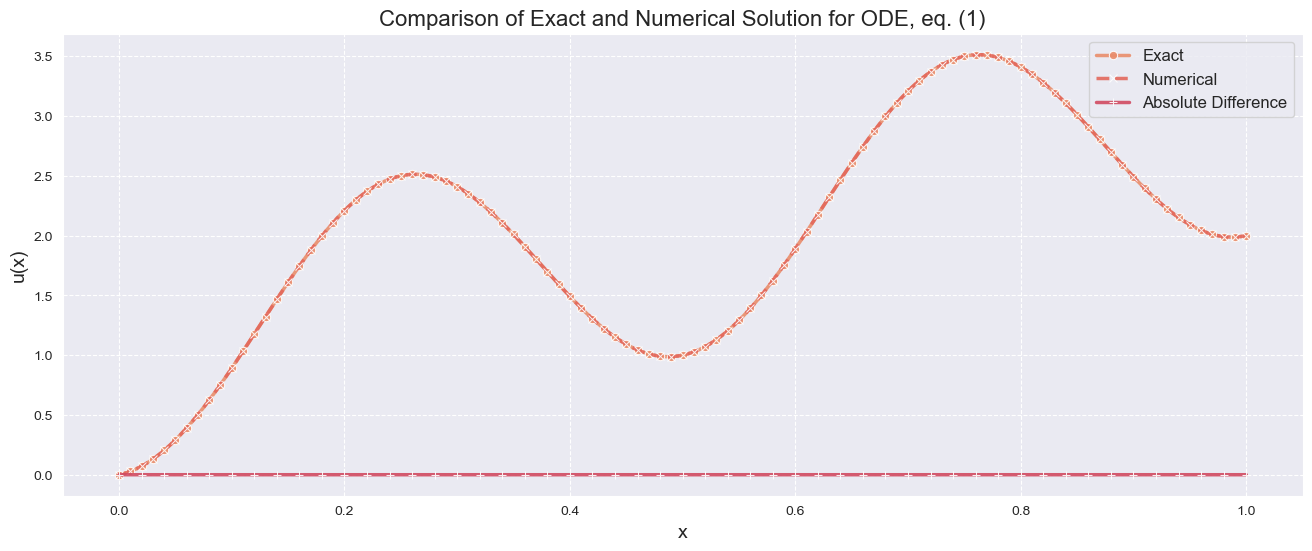

In [120]:
sns.set_style("darkgrid")
sns.set_palette("flare")

# problem conditions
N = 10000
x_span = [0,1]
u0 = 0 
u1 = 2

# load in the exact values
exact_x, exact_u = read_dat_file("solutionA_N10000.dat")
# comput data points
numerical_x_Ne4, numerical_u_Ne4 = solve_bvp(ode_eq1, x_span, u0, u1, N)
abs_u_difference = np.abs(exact_u - numerical_u_Ne4)

# Plot the data
plt.figure(figsize=(16, 6))
# Exact solution
sns.lineplot(x=exact_x, y=exact_u, marker='o', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=100, label="Exact")
# Numerical solution
sns.lineplot(x=numerical_x_Ne4, y=numerical_u_Ne4, marker='x', markersize=6, linestyle='--', linewidth=2.5, alpha=0.9, markevery=100, label="Numerical")
# Absolute difference (log scale for better visualization)
sns.lineplot(x=exact_x, y=abs_u_difference, marker='+', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=200, label="Absolute Difference")

# xlabel, ylabel, title, etc.
plt.xlabel("x", fontsize=14), plt.ylabel("u(x)", fontsize=14), plt.title("Comparison of Exact and Numerical Solution for ODE, eq. (1)", fontsize=16)
plt.legend(fontsize=12), plt.grid(True, linestyle="--", alpha=1)

# Show plot
plt.show()


**As we can see from the actual data points themselves and the absolute difference between two methods, our results from BVP solver is very accurate. We'll proceed with this function.**

### Solution for $ N = 10 $ and Tabular Format
We will compute our numerical solution for the case $N = 10$ and print the results in a tabular format.

In [121]:
N = 10
# obtain numerical solution for N = 10
numeric_x_N10, numeric_u_N10 = solve_bvp(ode_eq1, x_span, u_i=u0, u_f=u1, N=N)
# make a pandas Dataframe for tabular format
df_N10  = pd.DataFrame(data={
    'x_i':numeric_x_N10,
    'u_i': numeric_u_N10
    }, index=pd.Index(range(N+2), name='N'))
# Display DataFrame with LaTeX
display(HTML(df_N10.to_html()))

,x_i,u_i
N,,
0,0.000000,0.000000
1,0.090909,0.834354
2,0.181818,2.210854
3,0.272727,2.732715
4,0.363636,2.002368
5,0.454545,1.086290
6,0.545455,1.268108
7,0.636364,2.547822
8,0.727273,3.641805


---
## Question 3
### Error Analysis for various values of $N$

We will compute the numerical solution for different values of $N$ and compare it against the exact solution ($N=10^4$). The errors are defined as:

$$
E = \left[ \sum_{i=1}^{N} (u_i - \tilde{u}_i)^2 \right]^{\frac{1}{2}}
$$

$$
e = \frac{1}{N} \left[ \sum_{i=1}^{N} (u_i - \tilde{u}_i)^2 \right]^{\frac{1}{2}}
$$

where:
- $u_i$ is the numerical solution
- $\tilde{u}_i$ is the interpolated exact solution at $x_i$
- $h = (N+1)^{-1}$ is the step size.

We will compute the errors for:

$$
N = \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}
$$

and fit a function of the form:

$$
E = C h^{\alpha}
$$

#### Interpolation of the Exact Solution

Since the exact solution is only available at a fine grid ($N=10^4$), we must interpolate it to match the grid points of the numerical solutions ($N=5,10,20,\dots,1280$). 

To ensure accurate error calculations:
- The exact solution $\tilde{u}_i$ should be evaluated **at the same $x_i$ points** as the numerical solution.
- We use **shape-preserving interpolation** (`PchipInterpolator`) to minimize oscillations and avoid large interpolation errors.
- The interpolation error **must be smaller** than the numerical error we are analyzing.



In [122]:
# store different number of steps
steps = np.array([5, 10, 20, 40, 80, 160, 320, 640, 1280], dtype = int)
# we will first compute different step-sizes h and store it
step_sizes = 1 / (steps + 1)

# Solve BVP for multiple step values and store results in lists
numeric_solutions = [solve_bvp(ode_eq1, x_span, u0, u1, N) for N in steps]
# Extract x and u values for each N
numeric_Xs = [np.array(sol[0], dtype=float) for sol in numeric_solutions]  # Extract all x values
numeric_Us = [np.array(sol[1], dtype=float) for sol in numeric_solutions]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x, exact_u)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us = [interpolator(Xs) for Xs in numeric_Xs]

#### Log-log plot that shows $E$ and $e$ versus $h^{-1}$

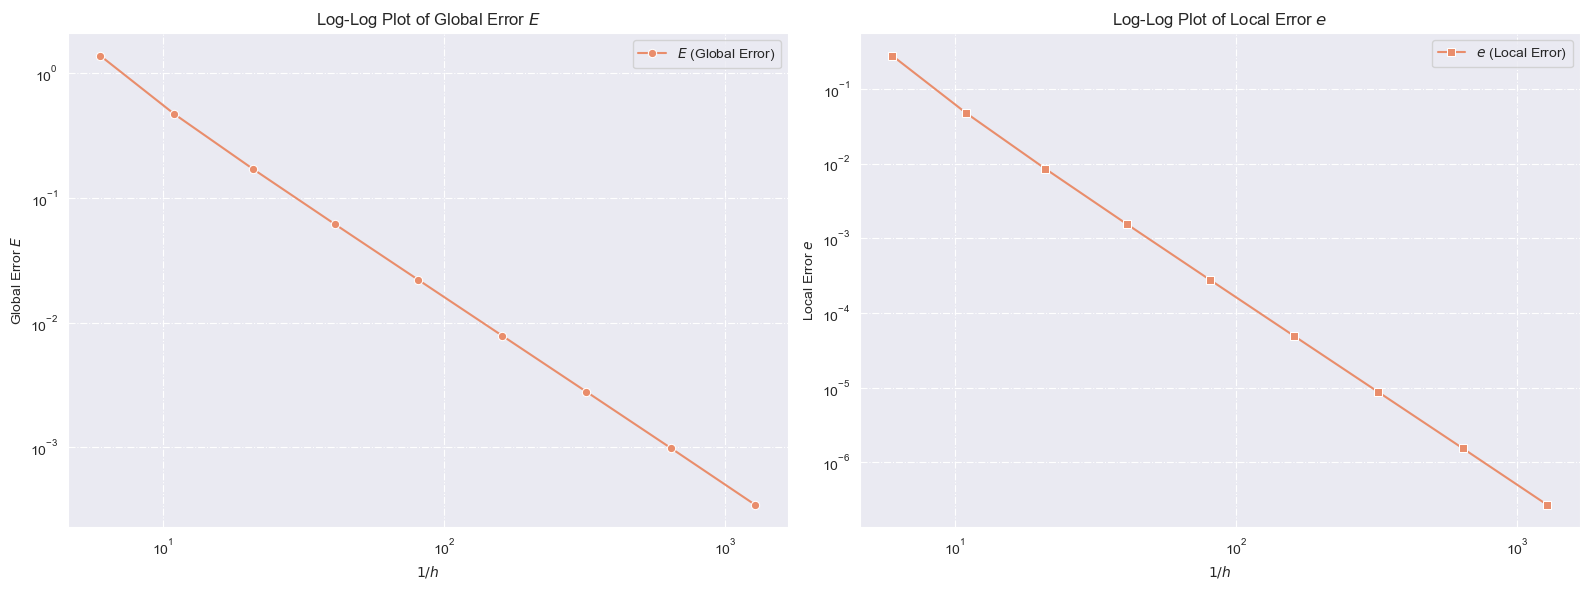

In [123]:
def compute_errors(N, exact: np.array, numerical: np.array) -> float:
    """
    Computes global and local errors.

    Parameters:
        N (int): Number of interior points
        exact (np.array): Interpolated exact solution at grid points
        numerical (np.array): Numerical solution

    Returns:
        float, float: Global error (E) and Local error (e)
    """
    # compute global error, this is essentially L2 norm, which we can use numpy's vectorized function.
    global_error = np.linalg.norm(exact - numerical)
    # compute the local error, scaling by N
    local_error = global_error / float(N)

    return global_error, local_error

# compute errors for varying steps
global_errors = [compute_errors(steps[i], interpolated_exact_Us[i], numeric_Us[i])[0] for i in range(len(numeric_Us))] # global errors
local_errors = [compute_errors(steps[i], interpolated_exact_Us[i], numeric_Us[i])[1] for i in range(len(numeric_Us))] # local errors

# create a plot for E and e
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=False) # creare a subplot
sns.lineplot(x = 1 / step_sizes, y=global_errors, label=r"$E$ (Global Error)",marker='o', ax=axes[0])
# plot local error
sns.lineplot(x = 1 / step_sizes, y=local_errors, label=r"$e$ (Local Error)",marker='s', ax=axes[1])

# configurations
y_labels = ["Global Error $E$", "Local Error $e$"]
titles = ["Log-Log Plot of Global Error $E$", "Log-Log Plot of Local Error $e$"]
# apply all the configs
for i in range(2):
    axes[i].set_xscale("log"), axes[i].set_yscale("log") # set log-log scales
    axes[i].set_xlabel(r"$1/h$"), axes[i].set_ylabel(y_labels[i]) # set x and y labels
    axes[i].set_title(titles[i]) # set the tile
    axes[i].legend() # show the legend
    axes[i].grid(True, linestyle="dashdot", alpha=1.0)

plt.tight_layout()
plt.show()

#### Fitting $Ch^\alpha$ to Global and Local Errors
Here, we fit a function of the form $Ch^\alpha$ and report the value of $\alpha$ for both $\log(E)$ and $\log(e)$.
Then, we make a conclusion about the order of the errors $E$ and $e$ with respect to $h = (N + 1)^{-1}$.
Since we take the log of the function $Ch^\alpha$, our function becomes:

$$
\log(E) = \log(C) + \alpha \log(h)
$$

$$
\log(e) = \log(C) + \alpha \log(h)
$$

This transformation allows us to express the relationship in a linear form:

$$
y = m x + b
$$

where $y = \log(E)$ (or $\log(e)$), $x = \log(h)$, slope $m = \alpha$, and intercept $b = \log(C)$.


In [124]:
# for each global and local error, fit a linear function to get alpha
global_alpha = linregress(np.log(step_sizes), np.log(global_errors))[0] # global error alpha fitting
local_alpha = linregress(np.log(step_sizes), np.log(local_errors))[0] # local error alpha fitting

print(f"α for Global Error = {global_alpha:.3f}\nα for Local Error = {local_alpha:.3f}") # print till 3 decimal

α for Global Error = 1.531
α for Local Error = 2.558


#### **Interpretation of Results**
The expected theoretical behavior for a **second-order** finite difference method is:

- $E = \mathcal{O}(h^2)$ (global error)
- $e = \mathcal{O}(h^3)$ (local error)

Our computed values of $\alpha_{Global} \approx 1.53$ and $\alpha_{Local} \approx 2.56$ show that:

- **The method is converging**, but the **global order of accuracy is slightly lower than expected (same for local)**.
- Possible reasons for this include **discretization effects at boundaries**, **floating-point precision errors**, or **not using a fine enough grid to see asymptotic behavior**.
- Increasing $N$ further may improve the estimate of $\alpha$, making it closer to **2.0**.

**Conclusion**: The numerical method exhibits approximately second-order global convergence and higher-order local convergence. However, to verify full $\mathcal{O}(h^2)$ accuracy, additional refinements such as increasing $N$ should be considered. Since the smallest $h$ is only approximately $0.000781$, floating-point precision errors should not be a dominant factor at this scale. The observed discrepancy in the convergence rate is more likely due to discretization effects or not using a fine enough grid to see true asymptotic behavior.

---
## Question 4
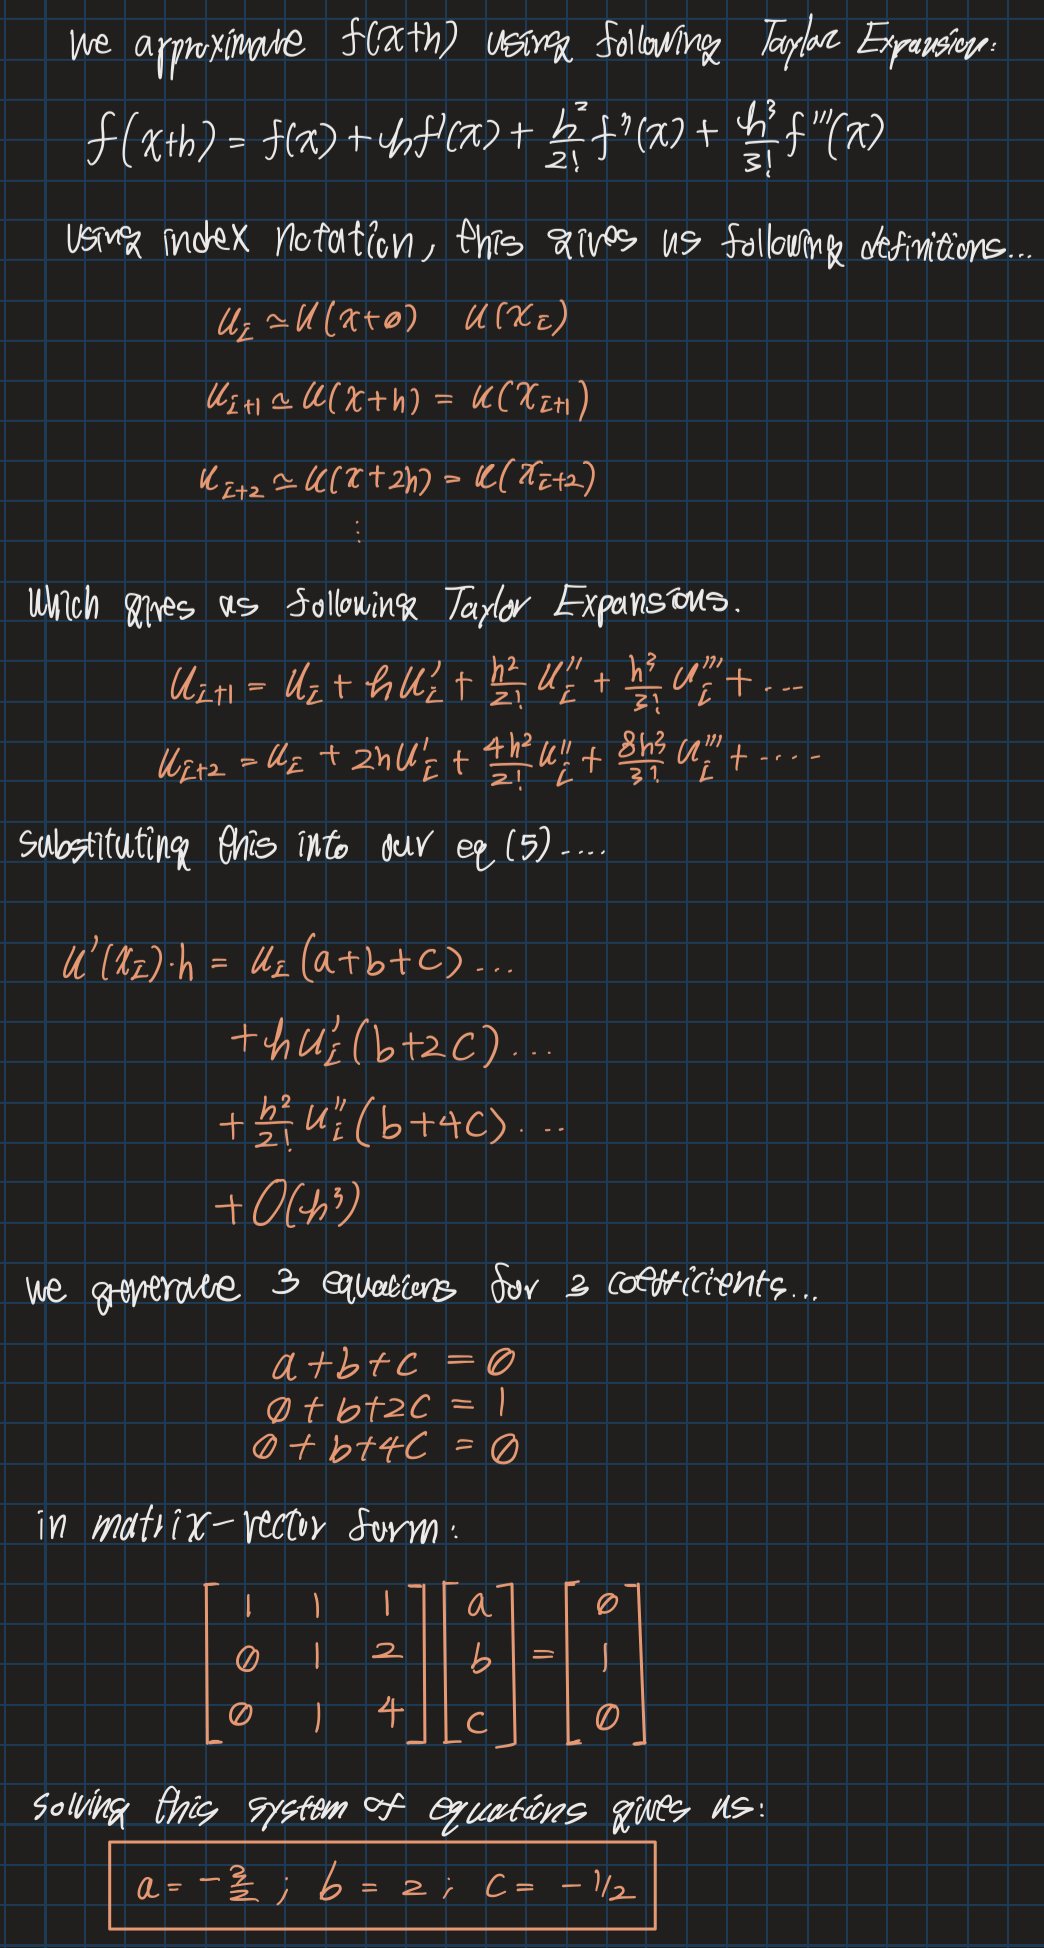

---
## Question 5
#### Numerical Solution of the BVP with Mixed Boundary Conditions
We aim to solve the given **Boundary Value Problem (BVP)** numerically using the **finite difference method**. The equation includes:

- A **Neumann boundary condition** at $x = 0$:  
  $$ u'(0) = 10 $$
- A **[Dirichlet boundary condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition)** at $x = 1$:  
  $$ u(1) = 2 $$

Unlike standard BVPs that specify values of $u(x)$ at both boundaries, this problem gives a **derivative condition at $x=0$**. Our solver was originally designed to handle only **Dirichlet conditions** (i.e., known $u(0)$ and $u(1)$), so we need to reformulate the problem.


### Handling the [Neumann Boundary](https://en.wikipedia.org/wiki/Neumann_boundary_condition) Condition
To incorporate $u'(0) = 10$ into our finite difference framework, we use the **one-sided second-order finite difference approximation** derived earlier from Q4:

$$ u'(0)h = a u_0 + b u_1 + c u_2 + \mathcal{O}(h^3) $$

Substituting the known derivative and the constants we solved previously in Q4:

$$ 10h = -1.5 u_0 + 2 u_1 -0.5 u_2 $$

This equation replaces the first row of our finite difference system, effectively enforcing the Neumann condition while still allowing us to use our **existing `solve_bvp`**.

### Key Changes in the Code

#### 1. Generalizing the Solver to Support Mixed Boundary Conditions
In the **original `solve_bvp` function**, the solver **assumed Dirichlet boundary conditions** at both ends. That meant we directly **subtracted known boundary values** from the RHS vector.

##### **New Update:**  
We introduced a **`boundary_conditions` dictionary** that allows the solver to handle **both Dirichlet and Neumann conditions dynamically**:
```python
boundary_conditions = {
    'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
    'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
}
```
This means the solver can now **check and apply the correct boundary type** at both \(x = 0\) and \(x = 1\).

#### 2. Modifying the Finite Difference Coefficient Matrix
In the **original solver**, we constructed a **tridiagonal coefficient matrix** assuming the standard second-order finite difference method:

$$
\frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} \approx f(x_i)
$$

##### **New Update:**  
For **Neumann conditions**, we modify the **first row** (for the left boundary) and/or the **last row** (for the right boundary) in the matrix to enforce derivative conditions.

- **Neumann at \( x=0 \) (Forward Difference Approximation)**  
  ```python
  coeff_matrix[0, :3] = np.array([-1.5, 2.0, -0.5])  # Forward difference stencil
  f[0] = boundary_conditions['left'][1] * h  # Move Neumann BC to RHS
  ```
  The **forward difference approximation** is given by:

  $$
  u'(0)h = -1.5 u_0 + 2 u_1 - 0.5 u_2 + \mathcal{O}(h^3)
  $$

  Since we are not solving for \( u_0 \) directly, we move \( u'(0) h \) to the RHS.

- **Neumann at \( x=1 \) (Backward Difference Approximation)**  
  ```python
  coeff_matrix[-1, -3:] = np.array([-0.5, 2.0, -1.5])  # Backward difference stencil
  f[-1] = boundary_conditions['right'][1] * h  # Move Neumann BC to RHS
  ```
  The **backward difference approximation** is given by:

  $$
  u'(1)h = -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N + \mathcal{O}(h^3)
  $$

  Again, we move \( u'(1) h \) to the RHS and modify the last row of the matrix.

These **one-sided approximations** allow us to incorporate the derivative conditions **without directly solving for \( u_0 \) or \( u_N \) in the system**.


#### 3. Computing the Boundary Values After Solving the System
In the **original solver**, after computing the numerical solution at interior points, we **directly assigned the boundary values** because they were known Dirichlet conditions:

```python
u[0], u[-1] = u_i, u_f
```

##### **New Update:**  
For **Neumann conditions**, we **compute the boundary values** using the rearranged one-sided difference formula:

$$
u_0 = \frac{2}{-3} \left( u'(0) h - 2 u_1 + 0.5 u_2 \right)
$$

$$
u_N = \frac{2}{-3} \left( u'(N) h - 2 u_{N-1} + 0.5 u_{N-2} \right)
$$

This ensures that the boundary values **properly reflect the derivative constraint**.

```python
if boundary_conditions['left'][0] == 'Neumann':
    u[0] = (2 / -3) * (u_prime0 * h - 2 * u_interior[0] + 0.5 * u_interior[1])

if boundary_conditions['right'][0] == 'Neumann':
    u[-1] = (2 / -3) * (u_primeN * h - 2 * u_interior[-1] + 0.5 * u_interior[-2])
```

#### To Summarize
The **updated solver** now supports **mixed boundary conditions**, allowing us to solve problems with **both Dirichlet and Neumann constraints**. The major mathematical modifications included:

- **Incorporating Neumann conditions into the matrix using one-sided finite differences**
- **Rearranging the system to solve for interior points first**
- **Explicitly computing boundary values after solving the system**

With these improvements, our solver is now **more flexible and generalizable**, making it applicable to a **wider range of BVPs**.

In [125]:
def solve_bvp(ode, x_range:list, N:int, boundary_conditions:dict) -> tuple:
    """
    Solves a boundary value problem (BVP) using the second-order finite difference (FDF) method.

    This function numerically solves the second-order ODE:

        u''(x) = f(x),

    using a finite difference discretization over a grid of N interior points. The second-order
    centered difference approximation for u''(x) is given by:

        (u_{i+1} - 2u_i + u_{i-1}) / h^2 ≈ f(x_i),

    where h is the grid spacing. The resulting system of linear equations is solved using matrix 
    inversion techniques.

    This solver also supports both Dirichlet and Neumann boundary conditions:
      - Dirichlet: u(0) = u0, u(1) = uN
      - Neumann: u'(0) = u'_0, u'(1) = u'_N (using second-order one-sided finite difference approximation)

    Parameters:
        ode (function): Function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        x_range (list): The domain range [x_start, x_end].
        N (int): The number of interior grid points.
        boundary_conditions (dict): Dictionary specifying boundary conditions:
            {
                'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
                'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
            }

    Returns:
        numpy.ndarray: x values including boundaries.
        numpy.ndarray: Computed numerical solution u(x).
    """
    
    # Extract domain boundaries
    x_i, x_f = x_range
    h = (x_f - x_i) / (N + 1)  # define step-size h:

    # -------------------------------------------
    # STEP 1: Construct Finite Difference Coefficient Matrix
    # -------------------------------------------
    # Create a tri-diagonal matrix for the finite difference discretization
    main_diag = -2 * np.ones(N, dtype=float)  # Main diagonal elements
    other_diag = np.ones(N-1, dtype=float)    # Superdiagonal & subdiagonal elements
    # Construct the coefficient matrix A using NumPy's diag function
    coeff_matrix = np.diag(main_diag, k=0) + np.diag(other_diag, k=1) + np.diag(other_diag, k=-1)

    # -------------------------------------------
    # STEP 2: Compute RHS, f vector
    # -------------------------------------------
    # Create grid points for the interior domain (excluding boundaries)
    x_interior = np.linspace(x_i + h, x_f - h, num=N, dtype=float)
    # Evaluate the ODE function at the interior points and scale by h^2
    f = ode(x_interior) * h**2

    # -------------------------------------------
    # STEP 3: Apply Boundary Conditions
    # -------------------------------------------
    # LEFT boundary condition
    if boundary_conditions['left'][0] == 'Dirichlet':
        # Dirichlet BC: Modify RHS to incorporate known boundary value
        # Since we already know u(0) = u_0, we subtract it from the first row of f.
        f[0] -= boundary_conditions['left'][1]
    elif boundary_conditions['left'][0] == 'Neumann':
        # Neumann BC: Approximate u'(0) using a one-sided difference formula:
        # Forward finite difference approximation:
        #     u'(x_0) ≈ (-1.5u_0 + 2u_1 - 0.5u_2) / (h) + O(h^2)
        # This formula uses the first three grid points (u_0, u_1, u_2).
        # We rewrite this in matrix form to modify the first row of A:
        #     (-1.5 u_0 + 2 u_1 - 0.5 u_2) / h = u'_0
        # Rearranging: -1.5 u_0 + 2 u_1 - 0.5 u_2 = h u'_0
        # Since we don't solve for u_0 directly, we move h * u'_0 to the RHS.
        u_prime0 = boundary_conditions['left'][1] * h
        f[0] = u_prime0  # Move the Neumann term to RHS
        # Modify the first row of the coefficient matrix to reflect this relation.
        coeff_matrix[0, :3] = np.array([-1.5, 2.0, -0.5])  # Forward difference stencil

    # RIGHT boundary condition
    if boundary_conditions['right'][0] == 'Dirichlet':
        # Dirichlet BC: Modify RHS to incorporate known boundary value
        # We already know u(1) = u_N, so we subtract it from the last row of f.
        f[-1] -= boundary_conditions['right'][1]
    elif boundary_conditions['right'][0] == 'Neumann':
        # Neumann BC: Approximate u'(1) using a one-sided difference formula:
        # Note: in this case, our 'wall' or 'boundary' is at the right side.
        # Thus, one sided starts at N, and goes to N-1, N-2, so on.
        # Backward finite difference approximation:
        #     u'(x_N) ≈ (1.5u_N - 2u_{N-1} + 0.5u_{N-2}) / (h) + O(h^2)
        # This formula uses the last three grid points (u_N, u_{N-1}, u_{N-2}).
        # We rewrite this in matrix form to modify the last row of A:
        #     (3 u_N - 4 u_{N-1} + u_{N-2}) / (2h) = u'_N
        # Rearranging: -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N = h u'_N
        # Again, we move h * u'_N to the RHS, since we are not solving for u_N directly.
        u_primeN = boundary_conditions['right'][1] * h
        f[-1] = u_primeN  # Move the Neumann term to RHS
        # Modify the last row of the coefficient matrix to reflect this relation.
        coeff_matrix[-1, -3:] = np.array([-0.5, 2.0, -1.5])  # Backward difference stencil

    # -------------------------------------------
    # STEP 4: Solve the Linear System
    # -------------------------------------------
    # Solve the system Ax = f for the unknown interior values
    u_interior = solve(coeff_matrix, f)

    # -------------------------------------------
    # STEP 5: Construct Full Solution Including Boundaries
    # -------------------------------------------
    x = np.empty(N + 2)  # Full grid including boundary points
    u = np.empty(N + 2)  # Full solution including boundary values
    # Assign interior grid values
    x[1:-1] = x_interior
    u[1:-1] = u_interior
    # Fill in boundary conditions
    # Assign boundary x values
    x[0], x[-1] = x_i, x_f
    # RIGHT Bondary
    if boundary_conditions['left'][0] == 'Dirichlet':
        u[0] = boundary_conditions['left'][1]
    elif boundary_conditions['left'][0] == 'Neumann':
        # Compute u_0 from the Neumann condition using equation (5):
        # Given the one-sided finite difference approximation:
        #     u'(x_0)h = a*u_0 + b*u_1 + c*u_2 + O(h^3)
        # Rearranging for u_0:
        #     u_0 = (1/a) * (u'(x_0)h - b*u_1 - c*u_2)
        # Plugging in the coefficients from equation (5) for second-order accuracy:
        #     u'(x_0) ≈ (-1.5u_0 + 2u_1 - 0.5u_2) / h + O(h^2)
        # Solving for u_0:
        #     -1.5u_0 = u'(x_0)h - 2u_1 + 0.5u_2
        #     u_0 = (2 / -3) * (u'(x_0) * h - 2 * u_1 + 0.5 * u_2)
        #u[0] = (2 / -3) * (u_prime0 * h - 2 * u_interior[0] + 0.5 * u_interior[1])
        u[0] = (2 / -3) * (u_prime0 * h - 2 * u[1] + 0.5 * u[2])

    # LEFT Boundary
    if boundary_conditions['right'][0] == 'Dirichlet':
        u[-1] = boundary_conditions['right'][1]
    elif boundary_conditions['right'][0] == 'Neumann':
        # Compute u_N from the Neumann condition using equation (5):
        # Similar to the left boundary, we approximate u'(x_N) as:
        #     u'(x_N) ≈ (1.5u_N - 2u_{N-1} + 0.5u_{N-2}) / h + O(h^2)
        # Rearranging for u_N:
        #     1.5u_N = u'(x_N)h + 2u_{N-1} - 0.5u_{N-2}
        #     u_N = (2 / -3) * (u'(x_N) * h - 2 * u_{N-1} + 0.5 * u_{N-2})
        #u[-1] = (2 / -3) * (u_primeN * h - 2 * u_interior[-1] + 0.5 * u_interior[-2])
        u[-1] = (2 / -3) * (u_primeN * h - 2 * u[-2] + 0.5 * u[-3])

    return x, u


### Plot Numerical Solution Against the Exact Solution (solutionB_N10000.dat)
Here, we confirm that our newly updated BVP solver works as intended, minizming error compared to the exact solution. **As we can see below, our numerical solution matches very closely with the exact one. We can also see the line for absolute difference between two data staying basically at $u(x) = 0$.**

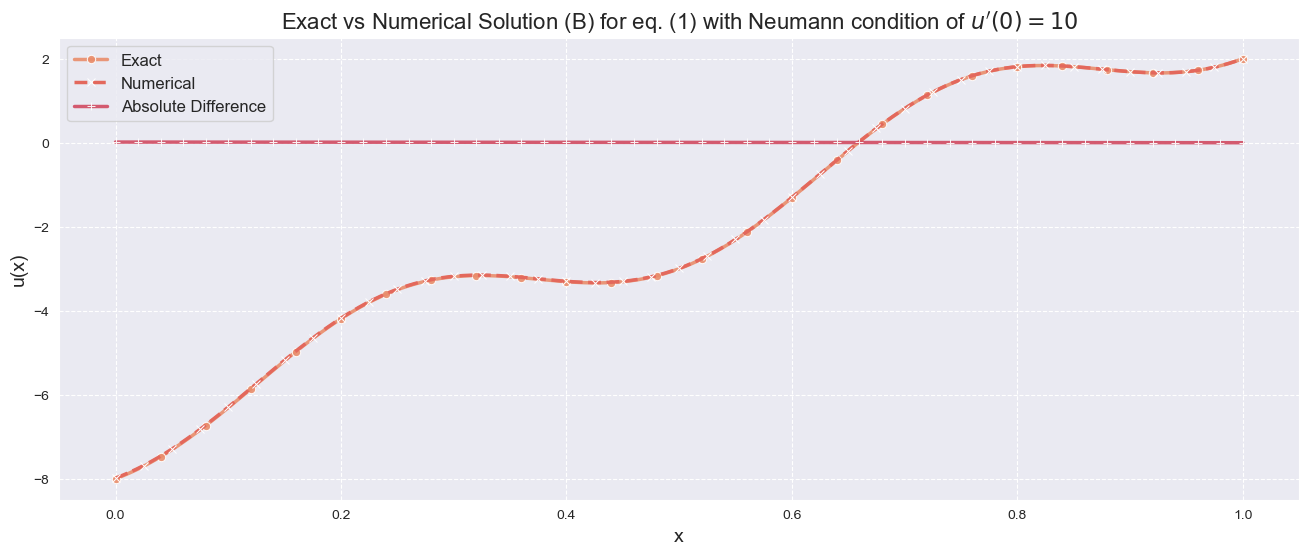

In [126]:
# first define the boundary conditions
Mixed_boundary_conditions={'left': ('Neumann', 10), 'right': ('Dirichlet', 2)}
# load in the exact solution
exact_x_B, exact_u_B = read_dat_file("solutionB_N10000.dat")
numerical_x_Ne4_B, numerical_u_Ne4_B = solve_bvp(ode_eq1, [0,1], N=10000,  boundary_conditions=Mixed_boundary_conditions)
# comput data points
abs_u_difference_B = np.abs(exact_u_B - numerical_u_Ne4_B)

# Plot the data.
plt.figure(figsize=(16, 6)) # create a figure
# Exact solution
sns.lineplot(x=exact_x_B, y=exact_u_B, marker='o', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=400, label="Exact")
# Numerical solution
sns.lineplot(x=numerical_x_Ne4_B, y=numerical_u_Ne4_B, marker='x', markersize=6, linestyle='--', linewidth=2.5, alpha=1., markevery=250, label="Numerical")
# Absolute difference
sns.lineplot(x=exact_x, y=abs_u_difference_B, marker='+', markersize=6, linestyle='-', linewidth=2.5, alpha=0.9, markevery=200, label="Absolute Difference")

# xlabel, ylabel, title, etc.
plt.xlabel("x", fontsize=14), plt.ylabel("u(x)", fontsize=14), plt.title(r"Exact vs Numerical Solution (B) for eq. (1) with Neumann condition of $u'(0) = 10$", fontsize=16)
plt.legend(fontsize=12), plt.grid(True, linestyle="--", alpha=1)

# Show plot
plt.show()

### Numerical Solution for $N = 10$ in Tabular Form
We compute the numerical solution for $eq(1)$ with the Neumann boundary condition of $u'(0) = 10$ for $N = 10$ and display it in tabular format.

In [127]:
N = 10
# obtain numerical solution for N = 10
numeric_x_N10_B, numeric_u_N10_B = solve_bvp(ode_eq1, x_span, N, boundary_conditions=Mixed_boundary_conditions)
# make a pandas Dataframe for tabular format
df_N10_B = pd.DataFrame({
    "x_i": numeric_x_N10_B,
    "u_i": numeric_u_N10_B
}, index=pd.Index(range(N+2), name="N"))  # Set N as the index
# Display DataFrame with LaTeX
display(HTML(df_N10_B.to_html()))

,x_i,u_i
N,,
0,0.000000,9.565963
1,0.090909,9.781650
2,0.181818,10.263420
3,0.272727,9.890551
4,0.363636,8.265475
5,0.454545,6.454667
6,0.545455,5.741756
7,0.636364,6.126740
8,0.727273,6.325994


---
## Question 6 (Extra Credit)

With our solve_BVP, we will go ahead and compute global and local errors when we use standard $2^{nd}$ order one-sided approximation for the boundary condition.

In [128]:
# first define the boundary conditions
Mixed_boundary_conditions={'left': ('Neumann', 10), 'right': ('Dirichlet', 2)}
# time
x_span = [0,1]
# store different number of steps
steps = np.array([5, 10, 20, 40, 80, 160, 320, 640, 1280], dtype = int)
# we will first compute different step-sizes h and store it
step_sizes = 1 / (steps + 1)

# Solve BVP for multiple step values and store results in lists
numeric_solutions_B = [solve_bvp(ode_eq1, x_span, N, Mixed_boundary_conditions) for N in steps]
# Extract x and u values for each N
numeric_Xs_B = [np.array(sol[0], dtype=float) for sol in numeric_solutions_B]  # Extract all x values
numeric_Us_B = [np.array(sol[1], dtype=float) for sol in numeric_solutions_B]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x_B, exact_u_B)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us_B = [interpolator(Xs) for Xs in numeric_Xs_B]

# compute errors for varying steps
global_errors_O2 = [compute_errors(steps[i], interpolated_exact_Us_B[i], numeric_Us_B[i])[0] for i in range(len(numeric_Us_B))] # global errors
local_errors_O2 = [compute_errors(steps[i], interpolated_exact_Us_B[i], numeric_Us_B[i])[1] for i in range(len(numeric_Us_B))] # local errors

To use 1st order one-sided approximation, we have to tweak our original BVP solver.
### Key Modifications in `solve_bvp_O1`

#### 1. Switching to a First-Order Finite Difference Approximation

In the previous version, a second-order approximation for Neumann conditions was used, which had the form:

$$
u'(x_0) \approx \frac{-1.5 u_0 + 2 u_1 - 0.5 u_2}{h}
$$

Now, it has been replaced with the first-order forward/backward difference formulas:

- **Forward Difference at** \( x = 0 \):

  $$
  u'(x_0) \approx \frac{u_1 - u_0}{h}
  $$

  Rearranging for \( u_0 \):

  $$
  u_0 = u_1 - h u'_0
  $$

- **Backward Difference at** \( x = 1 \):

  $$
  u'(x_N) \approx \frac{u_N - u_{N-1}}{h}
  $$

  Rearranging for \( u_N \):

  $$
  u_N = u_{N-1} + h u'_N
  $$

Implementation in the code:

```python
if boundary_conditions['left'][0] == 'Neumann':
    u[0] = u[1] - u_prime0 * h
if boundary_conditions['right'][0] == 'Neumann':
    u[-1] = u[-2] + u_primeN * h
```

This ensures that the solver enforces the first-order Neumann condition at the boundary.

#### 2. Modifying the Coefficient Matrix for First-Order Neumann Conditions

In the previous version, the first and last rows of the coefficient matrix were modified with a second-order stencil:

```python
coeff_matrix[0, :3] = np.array([-1.5, 2.0, -0.5]) / h  # Second-order forward difference
coeff_matrix[-1, -3:] = np.array([-0.5, 2.0, -1.5]) / h  # Second-order backward difference
```

Now, since the first-order approximation is used, the coefficients are simpler:

```python
coeff_matrix[0, :2] = np.array([-1., 1.])  # First-order forward difference
coeff_matrix[-1, -2:] = np.array([1., -1.])  # First-order backward difference
```

These correspond to:

- **Forward difference at** \( x = 0 \):

  $$
  u'_0 = \frac{u_1 - u_0}{h}
  $$

- **Backward difference at** \( x = 1 \):

  $$
  u'_N = \frac{u_N - u_{N-1}}{h}
  $$

#### Expected Impact of First-Order Approximation

1. **Lower Accuracy**  
   - The second-order approximation has an error term of $ O(h^2) $, meaning the error decreases quadratically as $ h $ decreases.
   - The first-order approximation has an error term of $ O(h) $, meaning the error decreases linearly.
   - This means that the numerical solution will be less accurate when using the first-order method.

2. **Comparison with Second-Order Scheme**  
   - Since the rest of the finite difference method remains second-order accurate, this change only affects the boundary conditions.
   - When plotting the log-log error, the slope of the error decay will change:
     - For second-order Neumann, the error decay should be approximately $ O(h^2) $.
     - For first-order Neumann, the error decay should be approximately $ O(h) $.

In [129]:
def solve_bvp_O1(ode, x_range:list, N:int, boundary_conditions:dict) -> tuple:
    """
    Solves a boundary value problem (BVP) using the second-order finite difference (FDF) method.

    This function numerically solves the second-order ODE:

        u''(x) = f(x),

    using a finite difference discretization over a grid of N interior points. The second-order
    centered difference approximation for u''(x) is given by:

        (u_{i+1} - 2u_i + u_{i-1}) / h^2 ≈ f(x_i),

    where h is the grid spacing. The resulting system of linear equations is solved using matrix 
    inversion techniques.

    This solver also supports both Dirichlet and Neumann boundary conditions:
      - Dirichlet: u(0) = u0, u(1) = uN
      - Neumann: u'(0) = u'_0, u'(1) = u'_N (using second-order one-sided finite difference approximation)

    Parameters:
        ode (function): Function representing the right-hand side of the ODE, f(x) in u''(x) = f(x).
        x_range (list): The domain range [x_start, x_end].
        N (int): The number of interior grid points.
        boundary_conditions (dict): Dictionary specifying boundary conditions:
            {
                'left': ('Dirichlet', u0) OR ('Neumann', u'_0),
                'right': ('Dirichlet', uN) OR ('Neumann', u'_N)
            }

    Returns:
        numpy.ndarray: x values including boundaries.
        numpy.ndarray: Computed numerical solution u(x).
    """
    
    # Extract domain boundaries
    x_i, x_f = x_range
    h = (x_f - x_i) / (N + 1)  # define step-size h:

    # -------------------------------------------
    # STEP 1: Construct Finite Difference Coefficient Matrix
    # -------------------------------------------
    # Create a tri-diagonal matrix for the finite difference discretization
    main_diag = -2 * np.ones(N, dtype=float)  # Main diagonal elements
    other_diag = np.ones(N-1, dtype=float)    # Superdiagonal & subdiagonal elements
    # Construct the coefficient matrix A using NumPy's diag function
    coeff_matrix = np.diag(main_diag, k=0) + np.diag(other_diag, k=1) + np.diag(other_diag, k=-1)

    # -------------------------------------------
    # STEP 2: Compute RHS, f vector
    # -------------------------------------------
    # Create grid points for the interior domain (excluding boundaries)
    x_interior = np.linspace(x_i + h, x_f - h, num=N, dtype=float)
    # Evaluate the ODE function at the interior points and scale by h^2
    f = ode(x_interior) * h**2

    # -------------------------------------------
    # STEP 3: Apply Boundary Conditions
    # -------------------------------------------
    # LEFT boundary condition
    if boundary_conditions['left'][0] == 'Dirichlet':
        # Dirichlet BC: Modify RHS to incorporate known boundary value
        # Since we already know u(0) = u_0, we subtract it from the first row of f.
        f[0] -= boundary_conditions['left'][1]
    elif boundary_conditions['left'][0] == 'Neumann':
        # Neumann BC: Approximate u'(0) using a one-sided difference formula:
        # Forward finite difference approximation:
        #     u'(x_0) ≈ (-1.5u_0 + 2u_1 - 0.5u_2) / (h) + O(h^2)
        # This formula uses the first three grid points (u_0, u_1, u_2).
        # We rewrite this in matrix form to modify the first row of A:
        #     (-1.5 u_0 + 2 u_1 - 0.5 u_2) / h = u'_0
        # Rearranging: -1.5 u_0 + 2 u_1 - 0.5 u_2 = h u'_0
        # Since we don't solve for u_0 directly, we move h * u'_0 to the RHS.
        u_prime0 = boundary_conditions['left'][1] * h
        f[0] = u_prime0  # Move the Neumann term to RHS
        # Modify the first row of the coefficient matrix to reflect this relation.
        coeff_matrix[0, :2] = np.array([-1., 1.])  # Forward difference stencil

    # RIGHT boundary condition
    if boundary_conditions['right'][0] == 'Dirichlet':
        # Dirichlet BC: Modify RHS to incorporate known boundary value
        # We already know u(1) = u_N, so we subtract it from the last row of f.
        f[-1] -= boundary_conditions['right'][1]
    elif boundary_conditions['right'][0] == 'Neumann':
        # Neumann BC: Approximate u'(1) using a one-sided difference formula:
        # Note: in this case, our 'wall' or 'boundary' is at the right side.
        # Thus, one sided starts at N, and goes to N-1, N-2, so on.
        # Backward finite difference approximation:
        #     u'(x_N) ≈ (1.5u_N - 2u_{N-1} + 0.5u_{N-2}) / (h) + O(h^2)
        # This formula uses the last three grid points (u_N, u_{N-1}, u_{N-2}).
        # We rewrite this in matrix form to modify the last row of A:
        #     (3 u_N - 4 u_{N-1} + u_{N-2}) / (2h) = u'_N
        # Rearranging: -0.5 u_{N-2} + 2 u_{N-1} - 1.5 u_N = h u'_N
        # Again, we move h * u'_N to the RHS, since we are not solving for u_N directly.
        u_primeN = boundary_conditions['right'][1] * h
        f[-1] = u_primeN  # Move the Neumann term to RHS
        # Modify the last row of the coefficient matrix to reflect this relation.
        coeff_matrix[-1, -2:] = np.array([1., -1.])  # Backward difference stencil

    # -------------------------------------------
    # STEP 4: Solve the Linear System
    # -------------------------------------------
    # Solve the system Ax = f for the unknown interior values
    u_interior = solve(coeff_matrix, f)

    # -------------------------------------------
    # STEP 5: Construct Full Solution Including Boundaries
    # -------------------------------------------
    x = np.empty(N + 2)  # Full grid including boundary points
    u = np.empty(N + 2)  # Full solution including boundary values
    # Assign interior grid values
    x[1:-1] = x_interior
    u[1:-1] = u_interior
    # Fill in boundary conditions
    # Assign boundary x values
    x[0], x[-1] = x_i, x_f
    # RIGHT Bondary
    if boundary_conditions['left'][0] == 'Dirichlet':
        u[0] = boundary_conditions['left'][1]
    elif boundary_conditions['left'][0] == 'Neumann':
        # Compute u_0 from the Neumann condition using equation (5):
        # Given the one-sided finite difference approximation:
        #     u'(x_0)h = a*u_0 + b*u_1 + c*u_2 + O(h^3)
        # Rearranging for u_0:
        #     u_0 = (1/a) * (u'(x_0)h - b*u_1 - c*u_2)
        # Plugging in the coefficients from equation (5) for second-order accuracy:
        #     u'(x_0) ≈ (-1.5u_0 + 2u_1 - 0.5u_2) / h + O(h^2)
        # Solving for u_0:
        #     -1.5u_0 = u'(x_0)h - 2u_1 + 0.5u_2
        #     u_0 = (2 / -3) * (u'(x_0) * h - 2 * u_1 + 0.5 * u_2)
        u[0] = u[1] - u_prime0 * h 
    # LEFT Boundary
    if boundary_conditions['right'][0] == 'Dirichlet':
        u[-1] = boundary_conditions['right'][1]
    elif boundary_conditions['right'][0] == 'Neumann':
        # Compute u_N from the Neumann condition using equation (5):
        # Similar to the left boundary, we approximate u'(x_N) as:
        #     u'(x_N) ≈ (1.5u_N - 2u_{N-1} + 0.5u_{N-2}) / h + O(h^2)
        # Rearranging for u_N:
        #     1.5u_N = u'(x_N)h + 2u_{N-1} - 0.5u_{N-2}
        #     u_N = (2 / -3) * (u'(x_N) * h - 2 * u_{N-1} + 0.5 * u_{N-2})
        u[-1] = u[-2] - u_primeN * h

    return x, u


Now, with this new function, we attain the global and local errors for varying steps again, but now for $1^{st}$ order of one-sided approximation.

In [130]:
# Solve BVP for multiple step values and store results in lists
numeric_solutions_B_O1 = [solve_bvp_O1(ode_eq1, x_span, N, Mixed_boundary_conditions) for N in steps]
# Extract x and u values for each N
numeric_Xs_B_O1 = [np.array(sol[0], dtype=float) for sol in numeric_solutions_B_O1]  # Extract all x values
numeric_Us_B_O1 = [np.array(sol[1], dtype=float) for sol in numeric_solutions_B_O1]  # Extract all u values
# Create an interpolator object for multiple uses
interpolator = PchipInterpolator(exact_x_B, exact_u_B)
# Interpolate "exact" solutions at different N values, INCLUDING boundary conditions
interpolated_exact_Us_B_O1 = [interpolator(Xs) for Xs in numeric_Xs_B_O1]

# compute errors for varying steps
global_errors_O1 = [compute_errors(steps[i], interpolated_exact_Us_B_O1[i], numeric_Us_B_O1[i])[0] for i in range(len(numeric_Us_B_O1))] # global errors
local_errors_O1 = [compute_errors(steps[i], interpolated_exact_Us_B_O1[i], numeric_Us_B_O1[i])[1] for i in range(len(numeric_Us_B_O1))] # local errors

#### Log-log plot that shows $E$ and $e$ versus $h^{-1}$ for both $1^{st}$ and $2^{nd}$ order BVP solvers.

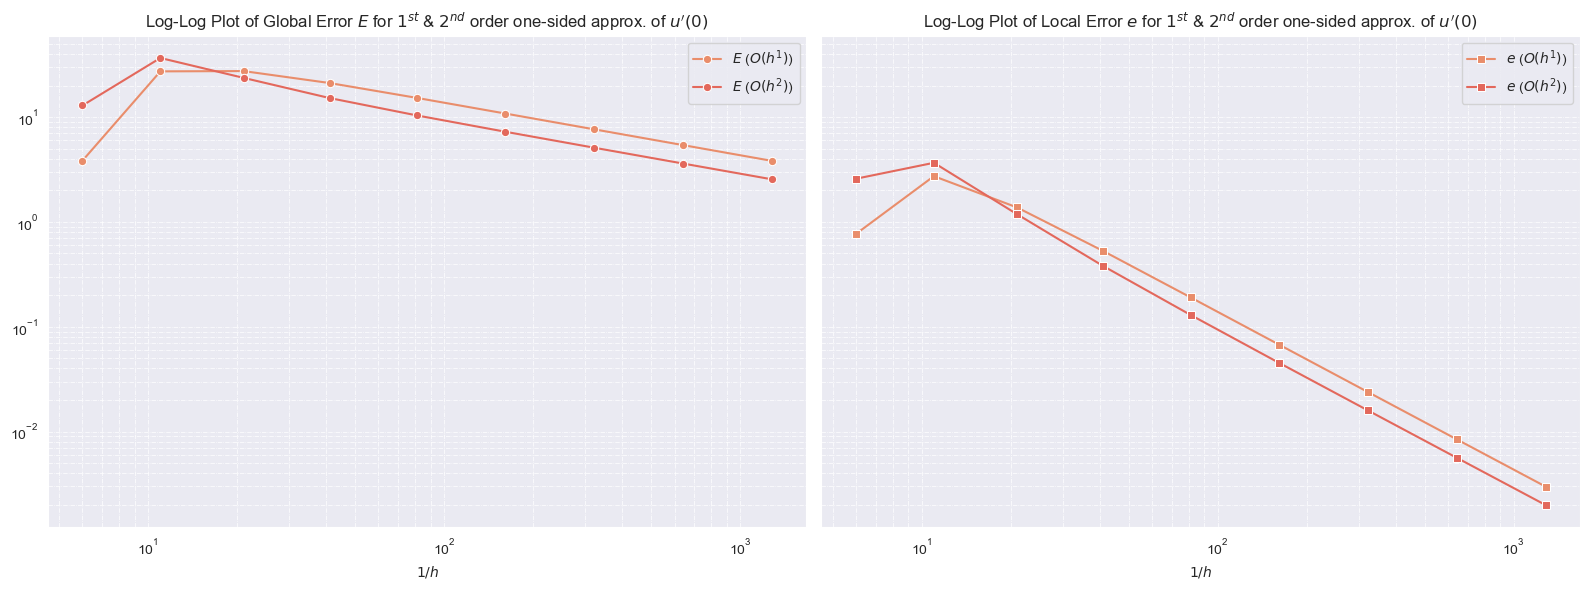

|    |   $N$ |        $h$ |   $E: O(h^1)$ |   $E: O(h^2)$ |   $e: O(h^1)$ |   $e: O(h^2)$ |
|---:|------:|-----------:|--------------:|--------------:|--------------:|--------------:|
|  0 |     5 | 0.166667   |       3.8411  |      12.9125  |    0.76822    |    2.58249    |
|  1 |    10 | 0.0909091  |      27.3272  |      36.6673  |    2.73272    |    3.66673    |
|  2 |    20 | 0.047619   |      27.5008  |      23.6976  |    1.37504    |    1.18488    |
|  3 |    40 | 0.0243902  |      21.1552  |      15.2113  |    0.52888    |    0.380281   |
|  4 |    80 | 0.0123457  |      15.2476  |      10.3734  |    0.190595   |    0.129667   |
|  5 |   160 | 0.00621118 |      10.8195  |       7.25138 |    0.0676216  |    0.0453211  |
|  6 |   320 | 0.00311526 |       7.65185 |       5.1084  |    0.023912   |    0.0159638  |
|  7 |   640 | 0.00156006 |       5.40897 |       3.60737 |    0.00845152 |    0.00563651 |
|  8 |  1280 | 0.00078064 |       3.82373 |       2.54944 |    0.00298729 |    0.00199175 |

In [131]:
# create a plot for E and e
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=True) # creare a subplot
sns.lineplot(x = 1 / step_sizes, y=global_errors_O1, label=r"$E$ ($O(h^1)$)",marker='o', ax=axes[0])
sns.lineplot(x = 1 / step_sizes, y=global_errors_O2, label=r"$E$ ($O(h^2)$)",marker='o', ax=axes[0])

# plot local error
sns.lineplot(x = 1 / step_sizes, y=local_errors_O1, label=r"$e$ ($O(h^1)$)",marker='s', ax=axes[1])
sns.lineplot(x = 1 / step_sizes, y=local_errors_O2, label=r"$e$ ($O(h^2)$)",marker='s', ax=axes[1])

# configurations
titles = [r"Log-Log Plot of Global Error $E$ for $1^{st}$ & $2^{nd}$ order one-sided approx. of $u'(0)$", r"Log-Log Plot of Local Error $e$ for $1^{st}$ & $2^{nd}$ order one-sided approx. of $u'(0)$"]
# apply all the configs
for i in range(2):
    axes[i].set_xscale("log"), axes[i].set_yscale("log") # set log-log scales
    axes[i].set_xlabel(r"$1/h$")
    axes[i].set_title(titles[i]) # set the tile
    axes[i].legend() # show the legend
    axes[i].grid(True, linestyle="dashdot", alpha=1.0, which='both', linewidth=0.5)
    axes[i].minorticks_on

plt.tight_layout()
plt.show()

# display them in tabular format as well.
data = np.array([steps, step_sizes, global_errors_O1, global_errors_O2, local_errors_O1, local_errors_O2]).T
# Create DataFrame
df_errors_Bonus = pd.DataFrame(data, columns=[r'$N$', r'$h$', r'$E: O(h^1)$', r'$E: O(h^2)$', r'$e: O(h^1)$', r'$e: O(h^2)$'])
display(Markdown(df_errors_Bonus.to_markdown()))

#### Fitting $Ch^\alpha$ to Global and Local Errors for both $1^{st}$ and $2^{nd}$ order BVP solvers.
Here, we fit a function of the form $Ch^\alpha$ and report the value of $\alpha$ for both $\log(E)$ and $\log(e)$.

In [132]:
# for each global and local error for 1st order, fit a linear function to get alpha
global_alpha_O1 = linregress(np.log(step_sizes), np.log(global_errors_O1))[0] # global error alpha fitting
local_alpha_O1 = linregress(np.log(step_sizes), np.log(local_errors_O1))[0] # local error alpha fitting
# for each global and local error for 2nd order, fit a linear function to get alpha
global_alpha_O2 = linregress(np.log(step_sizes), np.log(global_errors_O2))[0] # global error alpha fitting
local_alpha_O2 = linregress(np.log(step_sizes), np.log(local_errors_O2))[0] # local error alpha fitting
# print them in nice tabular form
data = np.array([[global_alpha_O1, global_alpha_O2, local_alpha_O1, local_alpha_O2]])
df_alphas_Bonus  = pd.DataFrame(data=data, columns=[r'$\alpha_{E, O(h^1)}$', r'$\alpha_{E, O(h^2)}$', r'$\alpha_{e, O(h^1)}$', r'$\alpha_{e, O(h^2)}$'])
display(Markdown(df_alphas_Bonus.to_markdown()))

|    |   $\alpha_{E, O(h^1)}$ |   $\alpha_{E, O(h^2)}$ |   $\alpha_{e, O(h^1)}$ |   $\alpha_{e, O(h^2)}$ |
|---:|-----------------------:|-----------------------:|-----------------------:|-----------------------:|
|  0 |               0.206756 |               0.429289 |                1.23402 |                1.45655 |

### Observations

#### 1. Error Convergence and Order of Accuracy  
From the log-log plots of global error $E$ and local error $e$, we observe that the errors decrease as $h$ decreases, indicating that the numerical method is converging.

1. **Global Error $E$ Convergence Rate:**  
   - The computed global error exponent for the first-order one-sided approximation is $ \alpha \approx 0.207 $.
   - The computed global error exponent for the second-order one-sided approximation is $ \alpha \approx 0.429 $.
   - These values are lower than the expected theoretical values ($O(h^1)$ for first order and $O(h^2)$ for second order), which suggests that the global error is influenced by other factors, possibly including accumulated numerical errors or discretization effects.

2. **Local Error $e$ Convergence Rate:**  
   - The computed local error exponent for the first-order one-sided approximation is $ \alpha \approx 1.234 $.
   - The computed local error exponent for the second-order one-sided approximation is $ \alpha \approx 1.457 $.
   - These values are closer to the expected theoretical values ($O(h^1)$ for first order and $O(h^2)$ for second order), **confirming that at a local level, the scheme behaves as expected.**

#### 2. Comparison of First-Order vs Second-Order Approximations  
1. **First-Order Approximation (Forward Difference)**  
   - The global error $E$ decreases at a lower rate ($ O(h^{0.207}) $), which indicates that the first-order boundary condition introduces a significant source of error in the system.
   - The local error $e$ converges at a rate close to $ O(h) $, confirming the expected behavior.

2. **Second-Order Approximation (More Accurate One-Sided Difference)**  
   - The global error $E$ decreases faster than the first-order method, with an approximate rate of $ O(h^{0.429}) $.
   - The local error $e$ converges at a rate close to $ O(h^2) $, demonstrating better accuracy near the boundaries.

#### 3. Why are errors so small at $N = 5$?  

- The log-log plots show that both the global and local errors for all orders of approximation are small at $N = 5$, even smaller than those at many higher values of $N$.  
- This behavior is counterintuitive and does not follow the expected theoretical trend in which the error should **systematically decrease** as $h$ decreases (i.e., as $N$ increases).  
- Some possible explanations for this unexpected behavior include:

1. **Coincidental Error Cancellation:**  
   - At very coarse discretizations (such as when $N = 5$), certain numerical errors from the finite difference scheme and boundary conditions may cancel each other out.  
   - This cancellation is likely **not systematic** and does not persist as $N$ increases, leading to deviations from expected error behavior.

2. **Boundary Condition Influence:**  
   - Since the Neumann boundary condition is applied at $x = 0$, the **discretization may interact differently** with the imposed boundary condition when there are very few points in the domain.  
   - With only 5 interior points, the weight of the boundary conditions in influencing the numerical solution is **relatively larger** compared to cases with finer grids.  

3. **Grid Resolution Artifacts:**  
   - When $N$ is small, the discretization may **not adequately capture the full behavior** of the differential equation across the domain.  
   - In such cases, the computed solution may not vary much, leading to **errors appearing smaller** simply because the solution itself is overly smooth.  
   - However, this does not definitively mean the solution is accurate—just that the numerical method is not resolving finer details of the solution.

4. **Lack of Sufficient Data Points for Error Scaling:**  
   - The expected convergence behavior of the error is a property that emerges **asymptotically** as $N$ grows.  
   - For very small $N$, the assumptions required for the standard **error scaling laws** ($O(h)$ or $O(h^2)$) may **not yet be valid**, leading to deviations from theoretical predictions.  

#### 4. Practical Implications  
- The second-order method is significantly more accurate than the first-order method, particularly for small $h$.
- Using a first-order approximation at the boundary degrades the overall accuracy, leading to higher global errors.
- The results confirm that higher-order boundary approximations are essential when solving BVPs numerically, as errors originating at the boundary propagate through the entire solution domain.